# This script convert graph dataset to adjacency matix and node vectors for machine learning
- Node information will be converted to n-dimensional vectors
    - There are three types of nodes: numeric values, compounds, and words
    - They will be converted to vectors by corresponding encoders
        - Compound encoder will calculate fingerprints of compounds and convert them to vectors by PCA, etc
        - Word encoder will convert words to vectors by BERT and PCA
        - Value encoder gives just numeric array (e.g., 1.2 will be (1.2,1.2,...))
- Graph conecction will be converted to adjacency matrixes

In [3]:
import sys
sys.path.append("../MIGraph/GraphConv/")
sys.path.append("../MIGraph/Encoders/")
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import warnings
from Config import Config
import glob
from ConvGraphScript import drawGraph
from PrepDataset import PrepDataset
warnings.filterwarnings('ignore')

#configuration is saved in Config.py
CF=Config()

#mode ["V"] means that values will be vhosen as problems
print("mode: ",CF.genre)
print("targetParamMode: ",CF.targetParamMode)

mode:  ['V']
targetParamMode:  True


# init encoders
- PrepDataset class 
    - MasterEncoder class
        - OE(other encoder): calc vectors for words
        - CE(compound encoder): calc vectors for compounds
        - VE(value encoder): calc vectors for values

In [5]:
#init compound encoder
PD=PrepDataset()
allCompundsPath="praparingGraphs/output/allcompounds.csv.gz"
PD.setCompoundEncoder(allCompundsPath)

100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 3723.31it/s]

number of smiles:  52
calculate fingerprints
error  [Cl-].[Cl-].[Zn2+]
error  [Cl-].[Cl-].[Cl-].[In3+]
error  [Cl-].[Cl-].[Cu2+]
error  [Cl-].[Cl-].[Ni2+]
loading files
compressing and scaling


In [6]:
#load graph files
graphbinList=glob.glob("praparingGraphs/output/*.graphbin")
print(graphbinList)

for file in tqdm(graphbinList):
    print(file)
    gl=joblib.load(file)
    PD.graphList.extend(gl)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

['praparingGraphs/output\\PEDOT_PSS_autoprocessedGraph.graphbin.graphbin']
praparingGraphs/output\PEDOT_PSS_autoprocessedGraph.graphbin.graphbin


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


# init value and word encoder
- at this step, all words in databases will be converted to vectors
- There are two modes of initialization, depending of the configuration in Config.py
    - If self.initWordEncoder=True
        - word vectors will be calculated by BERT
        - Please launch bert-server, like...
        - "bert-serving-start -model_dir uncased_L-24_H-1024_A-16"
        - after calculation, the resuls will be saved at "bin/BERT_docs.bin" as a dict. 
    - If self.initWordEncoder=False (default)
        - it will just refer the dict of "bin/BERT_docs.bin". (much faster!)
        - if you make a new database and include new words, you need to re-calculate word vectors by BERT

load BERT encoder
336


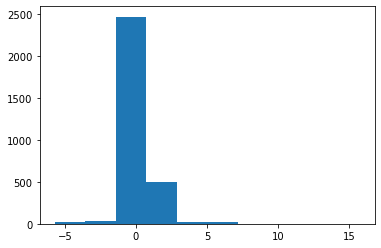

In [7]:
#init value and word encoder
PD.setScaler()
print(len(PD.graphList))

# prepare dataset
- the prepared graphs have been just graphs. We need make problems for machine learning
- convToDataset function will...
 1. find a node of [s/cm] in a graph.
 - find a neighboring node which has a numeric (= conductivity) info
 - the numeric node will be replaced with "__unknown__"
 - the concealed number will be an answer of the problem
 - then, all node info will be converted to vectors by encoders
 - the return will be a list of
     1. node vectors
     - adjacency matrix
     - answer
     - info of neighboring node


In [8]:
#parallel mode off
PD.parallel=False

#value nodes neighboring with [s/cm] will be a problem.
targetParams=["[s/cm]"]
trainDataset=PD.convToDataset(CF.genre,targetParams=targetParams)

 12%|██████████                                                                      | 42/336 [00:00<00:00, 418.23it/s]

process  336  graphs
converting graphs to vectors


100%|███████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 489.89it/s]
202it [00:00, 2010.14it/s]

converting nodes to problems


336it [00:00, 1361.03it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 422.50it/s]
312it [00:00, ?it/s]


In [9]:
joblib.dump(trainDataset,"bin/traindataset.bin",compress=9)

['bin/traindataset.bin']

In [11]:
#see how it was converted...
trainDataset[0]

(array([[-0.5794208 ,  0.97624564,  2.1745737 , ...,  0.10293594,
          0.00606985,  0.32400846],
        [-0.5794208 ,  0.97624564,  2.1745737 , ..., -0.01793946,
          0.8285798 , -0.532893  ],
        [-0.5794208 ,  0.97624564,  2.1745737 , ...,  0.3616248 ,
         -0.21796219,  0.025046  ],
        ...,
        [-0.5794208 ,  0.97624564,  2.1745737 , ..., -0.4704844 ,
         -0.84605175, -0.2769977 ],
        [-0.5794208 ,  0.97624564,  2.1745737 , ..., -0.329338  ,
         -0.5496915 ,  0.24944472],
        [-0.5794208 ,  0.97624564,  2.1745737 , ..., -0.5191979 ,
          1.1315479 , -0.31567222]], dtype=float32),
 array([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 array([-1.0701813], dtype=float32),
 '[s/cm]')